# loading the classes

In [1]:
import sys
sys.path.append('..')

from my_package.data_cleaning import *
from my_package.modeling import *
from my_package.preprocessing import *
from my_package.nn_modeling import *

# Splitting the data

In [2]:
def split_data(df,criteria='random'):
    X = df.drop(['fraud_bool'], axis=1)
    y = df['fraud_bool']
    if criteria=='paper':

        # Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
        X_train = X[X['month']<6]
        X_test = X[X['month']>=6]
        y_train = y[X['month']<6]
        y_test = y[X['month']>=6]


    elif criteria=='random':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    elif criteria=='stratify':

        X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

    X_train.drop('month', axis=1, inplace=True)
    X_test.drop('month', axis=1, inplace=True)
    return X_train, X_test, y_train, y_test

# reading the data

In [3]:
df=data_cleaning('Base.csv').get_data()

In [4]:
# split the data
X_train, X_test, y_train, y_test=split_data(df,criteria= 'paper')

# getting the groups:

In [5]:
train_groups=(X_train["customer_age"] > 50).map({True: ">50", False: "<=50"})
test_groups=(X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

# start the preprocessing

In [6]:
data = preprocessing(X_train, y_train)

# Scaling numerical features:

In [7]:
scalers = {}
for column in X_train.select_dtypes(include=['int','float']):
    m,scaler=data.scale_data('standard',column)
    scalers[column] = scaler

In [8]:
# apply the same scaling on the testset
for column in X_test.select_dtypes(include=['int','float']):
    X_test[column] = scalers[column].transform(X_test[[column]])

# encode the categorical features

In [9]:
encoders = {}
for column in X_train.select_dtypes(include=['category','object']):
    _, encoder = data.encode_categorical_features(column , encoding_type= 'one-hot')
    encoders[column] = encoder

In [10]:
# apply the encoding on the testset
for column in X_test.select_dtypes(include=['object','category']).columns:
    ohe=encoders[column]
    encoded_col = pd.DataFrame(ohe.transform(X_test[column].values.reshape(-1, 1)).toarray(),index=X_test.index)
    encoded_col.columns = [column + '_' + str(val) for val in ohe.categories_[0]]
    X_test = pd.concat([X_test, encoded_col], axis=1)
    X_test.drop(columns=column, inplace=True,axis=1)

In [11]:
# arrange the column names according to the concat data
X_test=X_test[data.concat_data().columns]

In [12]:
X_train,y_train=data.get_data()

# modeling : training and evaluation

In [13]:
experiment=modeling(X_train,X_test,y_train,y_test,train_groups,test_groups,name = 'catboost')

In [33]:
from catboost import CatBoostClassifier

# Define the CatBoost classifier
catboost_model = CatBoostClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'iterations': np.arange(100, 1000, 100),  # Number of boosting iterations
    'depth': np.arange(3, 9),               # Depth of the trees
    'learning_rate': [0.01, 0.05, 0.1], # Learning rate
    'l2_leaf_reg': [1, 3, 5],             # L2 regularization coefficient
    'class_weights':[{0:1,1:80}],
    'verbose':[0]
}

Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best hyperparameters: {'verbose': 0, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 400, 'depth': 5, 'class_weights': {0: 1, 1: 80}}
Best estimator: <catboost.core.CatBoostClassifier object at 0x0000029A8E658520>
Best score: 0.899535678672085
AUC: 0.8956503353169991
TPR:  55.14% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  86.27%


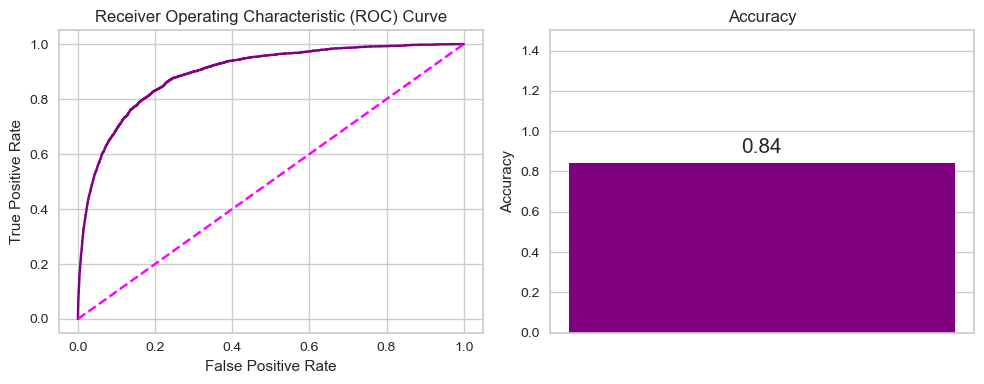

              precision    recall  f1-score   support

           0       1.00      0.84      0.91    202133
           1       0.07      0.79      0.12      2878

    accuracy                           0.84    205011
   macro avg       0.53      0.81      0.52    205011
weighted avg       0.98      0.84      0.90    205011



In [34]:
experiment.train(catboost_model,param_grid=param_grid,search_type='random')

In [35]:
# Save the best model
saved_model_path = experiment.save_model('catboost_model.pkl')
print("Model saved at:", saved_model_path)

Model saved at: catboost_model.pkl


In [47]:
import pickle

# Load the model from the pickle file
with open('catboost_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# after the new threshold

In [51]:
y_pred=loaded_model.predict_proba(X_test)[:,1]

In [52]:
y_pred_new_threshold = np.where(y_pred >= 0.76, 1, 0)

In [53]:
print(classification_report(y_test,y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.14      0.55      0.22      2878

    accuracy                           0.94    205011
   macro avg       0.56      0.75      0.59    205011
weighted avg       0.98      0.94      0.96    205011



In [54]:
print(confusion_matrix(y_test,y_pred_new_threshold))

[[191918  10215]
 [  1283   1595]]


- if we increase the threshold because we care about both the classes

In [56]:
y_pred_new_threshold = np.where(y_pred >= 0.81, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98    202133
           1       0.16      0.48      0.25      2878

    accuracy                           0.96    205011
   macro avg       0.58      0.72      0.61    205011
weighted avg       0.98      0.96      0.97    205011

[[195039   7094]
 [  1483   1395]]
